In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
# from SZstacker import SZMapStacker # type: ignore
from utils import ksz_from_delta_sigma, arcmin_to_comoving, comoving_to_arcmin

from stacker import SimulationStacker

import illustris_python as il

import yaml
import argparse
from pathlib import Path


In [32]:
import importlib
import stacker
importlib.reload(stacker)
from stacker import SimulationStacker


In [2]:
# Define configuration explicitly
from tabnanny import verbose

# Extract configuration parameters

redshift = 0.4
loadField = False
saveField = False
radDistance = 1.0
pType = 'gas'
projection = 'xy'
radDistanceUnits = 'arcmin'
pixelSize = 0.05  # arcmin/pixel

maskHaloes = False
maskRadii = 3.0
numRadii=11
minRadius_arcmin =1
maxRadius_arcmin = 6


sim_type = 'IllustrisTNG'
snapshot = 74
sim_name = 'L50n512_SB35'

# Plotting parameters

plotErrorBars = True
figName = 'DSigma_profiles_yz'

colourmaps = ['hot', 'cool']

sims = [0, 598, 580]

number_density = [2.4e-3, 1e-3, 5.4e-4, 2.8e-4, 1e-4]


t0 = time.time()




In [ ]:
mass_strings = [
    [
        f'n = {number_density[0]:.1e} (Mpc/h)$^{{-3}}$ (300 halos): 2.92e+12 ~ 2.78e+14 Msun/h',
        f'n = {number_density[1]:.1e} (Mpc/h)$^{{-3}}$ (125 halos): 7.74e+12 ~ 2.78e+14 Msun/h',
        f'n = {number_density[2]:.1e} (Mpc/h)$^{{-3}}$ (67 halos):  1.32e+13 ~ 2.78e+14 Msun/h',
        f'n = {number_density[3]:.1e} (Mpc/h)$^{{-3}}$ (35 halos):  2.01e+13 ~ 2.78e+14 Msun/h',
        f'n = {number_density[4]:.1e} (Mpc/h)$^{{-3}}$ (12 halos):  4.92e+13 ~ 2.78e+14 Msun/h'
    ],
    [
        f'n = {number_density[0]:.1e} (Mpc/h)$^{{-3}}$ (300 halos): 1.48e+11 ~ 2.74e+13 Msun/h',
        f'n = {number_density[1]:.1e} (Mpc/h)$^{{-3}}$ (125 halos): 3.10e+11 ~ 2.74e+13 Msun/h',
        f'n = {number_density[2]:.1e} (Mpc/h)$^{{-3}}$ (67 halos):  6.75e+11 ~ 2.74e+13 Msun/h',
        f'n = {number_density[3]:.1e} (Mpc/h)$^{{-3}}$ (35 halos):  1.45e+12 ~ 2.74e+13 Msun/h',
        f'n = {number_density[4]:.1e} (Mpc/h)$^{{-3}}$ (12 halos):  4.40e+12 ~ 2.74e+13 Msun/h'
    ],
    [
        f'n = {number_density[0]:.1e} (Mpc/h)$^{{-3}}$ (300 halos): 1.60e+12 ~ 1.44e+14 Msun/h',
        f'n = {number_density[1]:.1e} (Mpc/h)$^{{-3}}$ (125 halos): 3.89e+12 ~ 1.44e+14 Msun/h',
        f'n = {number_density[2]:.1e} (Mpc/h)$^{{-3}}$ (67 halos):  6.90e+12 ~ 1.44e+14 Msun/h',
        f'n = {number_density[3]:.1e} (Mpc/h)$^{{-3}}$ (35 halos):  1.14e+13 ~ 1.44e+14 Msun/h',
        f'n = {number_density[4]:.1e} (Mpc/h)$^{{-3}}$ (12 halos):  3.22e+13 ~ 1.44e+14 Msun/h'
    ]
]

## CHECKED: each smaller number density is a subset of the larger ones



In [3]:
mass_dropped_strings = [
    [
        f'n = {number_density[0]:.1e} (Mpc/h)$^{{-3}}$ (300-69=231 halos): 2.92e+12 ~ 2.78e+14 Msun/h',
        f'n = {number_density[1]:.1e} (Mpc/h)$^{{-3}}$ (125-27=98 halos): 7.74e+12 ~ 2.78e+14 Msun/h',
        f'n = {number_density[2]:.1e} (Mpc/h)$^{{-3}}$ (67-11=56 halos):  1.32e+13 ~ 2.78e+14 Msun/h',
        f'n = {number_density[3]:.1e} (Mpc/h)$^{{-3}}$ (35-6=29 halos):  2.01e+13 ~ 2.78e+14 Msun/h',
        f'n = {number_density[4]:.1e} (Mpc/h)$^{{-3}}$ (12-3=9 halos):  4.92e+13 ~ 2.78e+14 Msun/h'
    ],
    [
        f'n = {number_density[0]:.1e} (Mpc/h)$^{{-3}}$ (300-101=199 halos): 1.48e+11 ~ 2.74e+13 Msun/h',
        f'n = {number_density[1]:.1e} (Mpc/h)$^{{-3}}$ (125-45=80 halos): 3.10e+11 ~ 2.74e+13 Msun/h',
        f'n = {number_density[2]:.1e} (Mpc/h)$^{{-3}}$ (67-25=42 halos):  6.75e+11 ~ 2.74e+13 Msun/h',
        f'n = {number_density[3]:.1e} (Mpc/h)$^{{-3}}$ (35-15=20 halos):  1.45e+12 ~ 2.74e+13 Msun/h',
        f'n = {number_density[4]:.1e} (Mpc/h)$^{{-3}}$ (12-5=7 halos):  4.40e+12 ~ 2.74e+13 Msun/h'
    ],
    [
        f'n = {number_density[0]:.1e} (Mpc/h)$^{{-3}}$ (300-100=200 halos): 1.60e+12 ~ 1.44e+14 Msun/h',
        f'n = {number_density[1]:.1e} (Mpc/h)$^{{-3}}$ (125-44=81 halos): 3.89e+12 ~ 1.44e+14 Msun/h',
        f'n = {number_density[2]:.1e} (Mpc/h)$^{{-3}}$ (67-25=42 halos):  6.90e+12 ~ 1.44e+14 Msun/h',
        f'n = {number_density[3]:.1e} (Mpc/h)$^{{-3}}$ (35-10=25 halos):  1.14e+13 ~ 1.44e+14 Msun/h',
        f'n = {number_density[4]:.1e} (Mpc/h)$^{{-3}}$ (12-3=9 halos):  3.22e+13 ~ 1.44e+14 Msun/h'
    ]
]

## CHECKED: each smaller number density is a subset of the larger ones


# Cumulative Ratio

In [4]:

# Get colormap
colourmap = matplotlib.colormaps[colourmaps[0]]
colours = [colourmap(0.5)]  # Single color since we have one simulation

if verbose:
    print(f"Processing simulation of type: {sim_type}")

profiles0_all_sims = []
profiles1_all_sims = []
OmegaBaryons = []
OmegaMatters = []
HubbleParams = []

for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    stacker_tot = SimulationStacker(s, snapshot, 
                                simType=sim_type)

    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])
    HubbleParams.append(stacker.header['HubbleParam'])

    redshift = stacker.header['Redshift']
    cosmo = FlatLambdaCDM(H0=100 * stacker.header['HubbleParam'], Om0=stacker.header['Omega0'], Tcmb0=2.7255 * u.K, Ob0=stacker.header['OmegaBaryon'])
    minRad_mpch = arcmin_to_comoving(1.0, redshift, cosmo) / 1000.0 #0.34
    maxRad_mpch = arcmin_to_comoving(6.0, redshift, cosmo) / 1000.0 #2.05
    print(f"minRad_mpch: {minRad_mpch}, maxRad_mpch: {maxRad_mpch}")
    
    ## Corresponding to halo number in 50 Mpc/h box: [25, 68, 75, 125, 300]
    profiles0_all = []
    profiles1_all = []
    for n_density in number_density:
        radii0, profiles0  = stacker.stackField('gas', filterType='cumulative', minRadius=minRad_mpch, maxRadius=maxRad_mpch, numRadii=11, # type: ignore
                                                save=saveField, load=loadField, radDistance=1000, nPixels=1000,
                                                projection=projection, halo_number_density=n_density)
        radii1, profiles1 = stacker.stackField('total', filterType='cumulative', minRadius=minRad_mpch, maxRadius=maxRad_mpch, numRadii=11, # type: ignore
                                                save=saveField, load=loadField, radDistance=1000, nPixels=1000,
                                                projection=projection, halo_number_density=n_density)
        # radii0, profiles0 = stacker.stackMap('gas', filterType='cumulative', minRadius=1.0, maxRadius=6.0,
        #                                     save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
        #                                     projection=projection,pixelSize=pixelSize)
        # radii1, profiles1 = stacker_tot.stackMap('total', filterType='cumulative', minRadius=1.0, maxRadius=6.0,
        #                                         save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
        #                                         projection=projection, mask=maskHaloes, maskRad=maskRadii, pixelSize=pixelSize)

        profiles0_all.append(profiles0)
        profiles1_all.append(profiles1)

    profiles0_all_sims.append(profiles0_all)
    profiles1_all_sims.append(profiles1_all)


Processing simulation: L50n512_SB35 simulation 0
minRad_mpch: 0.3420903437680225, maxRad_mpch: 2.0525420626081345
Processed 0 snapshots, time elapsed: 2.80 seconds
Processed 0 snapshots, time elapsed: 2.80 seconds
Processed 10 snapshots, time elapsed: 22.43 seconds
Processed 10 snapshots, time elapsed: 22.43 seconds
Binned statistic time: 31.942808389663696
Binned statistic time: 31.942808389663696
Number of halos selected: 300 at Mass threshold:  2.78e+14 ~  3.21e+12 Msun/h
Number of halos selected: 300 at Mass threshold:  2.78e+14 ~  3.21e+12 Msun/h
Dropped 69 halos because too close to the box edge for CAP (sqrt(2)*maxR)
Processing particle type: gas
Processing particle type: DM
Data file '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/DM_1000_yz_2Dfield.npy' not found. Please compute it first.
Computing the field instead...
Dropped 69 halos because too close to the box edge for CAP (sqrt(2)*maxR)
Processing particle type: gas
Processing particle type: DM
Data 

In [ ]:
# # Save data in a format that handles variable array sizes
# save_data = {}
# save_data['radii0'] = radii0
# save_data['number_density'] = number_density
# save_data['sims'] = sims
# save_data['mass_strings'] = np.array(mass_strings, dtype=object)

# # Save tau and total profiles separately for each sim and density
# for sim_idx, sim_id in enumerate(sims):
#     for density_idx, density in enumerate(number_density):
#         gas_key = f'gas_sim{sim_id}_density{density_idx}'
#         total_key = f'total_sim{sim_id}_density{density_idx}'
#         save_data[gas_key] = profiles0_all_sims[sim_idx][density_idx]
#         save_data[total_key] = profiles1_all_sims[sim_idx][density_idx]

# np.savez(
#     f"CAMELS_{sim_name}_gas_cumulative_profiles_low_high_fiducial_feedback.npz",
#     **save_data
# ) 


In [ ]:
# Load the saved data
loaded_data = np.load(f"CAMELS_{sim_name}_gas_cumulative_profiles_low_high_fiducial_feedback.npz")

# Extract the basic arrays
radii0 = loaded_data['radii0']
number_density = loaded_data['number_density']
sims = loaded_data['sims']

# Reconstruct the profiles arrays
profiles0_all_sims = []
profiles1_all_sims = []

for sim_idx, sim_id in enumerate(sims):
    profiles0_all = []
    profiles1_all = []
    
    for density_idx, density in enumerate(number_density):
        gas_key = f'gas_sim{sim_id}_density{density_idx}'
        total_key = f'total_sim{sim_id}_density{density_idx}'
        
        profiles0_all.append(loaded_data[gas_key])
        profiles1_all.append(loaded_data[total_key])
    
    profiles0_all_sims.append(profiles0_all)
    profiles1_all_sims.append(profiles1_all)

print(f"Loaded data for {len(sims)} simulations with {len(number_density)} density bins")

(21, 231) (21, 231)
(21, 98) (21, 98)
(21, 56) (21, 56)
(21, 29) (21, 29)
(21, 10) (21, 10)
(21, 199) (21, 199)
(21, 80) (21, 80)
(21, 42) (21, 42)
(21, 20) (21, 20)
(21, 7) (21, 7)
(21, 200) (21, 200)
(21, 81) (21, 81)
(21, 42) (21, 42)
(21, 25) (21, 25)
(21, 9) (21, 9)


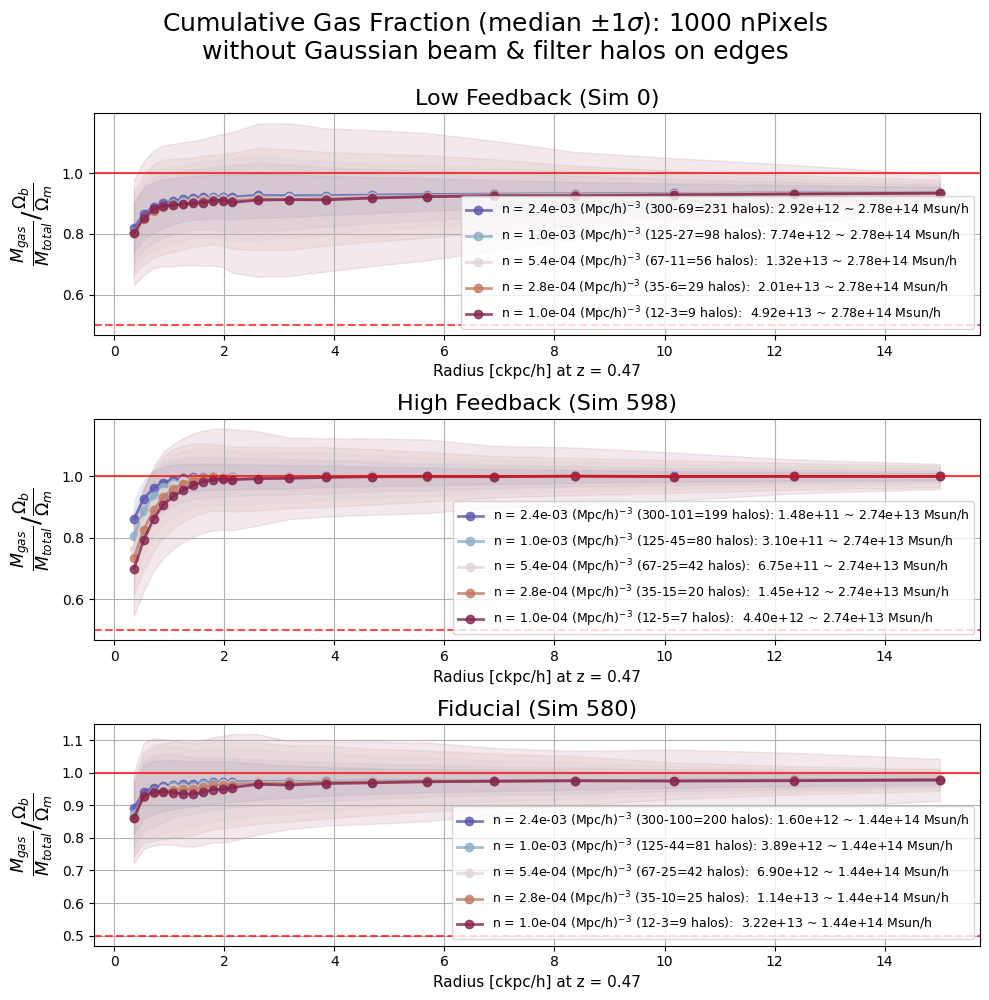

Processing completed in 625.60 seconds


In [10]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]

colourmap = cm.twilight_shifted

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
colors_list = colourmap(np.linspace(0.2, 0.85,  len(number_density)))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = profiles0_all_sims[sim_index]
    profiles1_all = profiles1_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i]
        profiles1 = profiles1_all[i]

        print(profiles0.shape, profiles1.shape)
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            title_label = f'Low Feedback (Sim {sims[sim_index]})'
        elif sim_index == 1:
            title_label = f'High Feedback (Sim {sims[sim_index]})'
        else:
            title_label = f'Fiducial (Sim {sims[sim_index]})'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls='-', alpha=0.8, marker='o', color=color, 
                       label=mass_dropped_strings[sim_index][i])

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(y=1.0, color='red', linestyle='-', linewidth=1.5, alpha=0.7)

    # Set labels and formatting for each subplot
    ax.set_xlabel(f'Radius [ckpc/h] at z = 0.47', size=11)
    ax.set_ylabel(r'$\frac{M_{gas}}{M_{total}}/\frac{\Omega_{b}}{\Omega_{m}} $', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label}', fontsize=16)

fig.suptitle(r'Cumulative Gas Fraction (median $\pm 1 \sigma$): 1000 nPixels' + '\n' + 'without Gaussian beam & filter halos on edges', fontsize=18, y=0.995)
fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

# $\Delta \Sigma$ Ratio

### Optimal Radial bins

In [28]:
stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    
minRad_mpch = arcmin_to_comoving(1.0, stacker.z, stacker.cosmo) / 1000.0
minRad_mpch_arcmin = comoving_to_arcmin(np.array([0.05* 1000.0 , 0.1* 1000.0, 0.5* 1000.0, 1* 1000.0])*1000, stacker.z, stacker.cosmo)

print(f"minRad_mpch: {minRad_mpch}, minRad_mpch_arcmin: {minRad_mpch_arcmin}")

minRad_mpch: 0.3584374077574465, minRad_mpch_arcmin: [ 139.49436894  278.98873788 1394.94368941 2789.88737882]


### stackMap

In [96]:
saveField = True
if verbose:
    print(f"Processing simulation of type: {sim_type}")

DSigma_profiles0_stackMap_all_sims = []
DSigma_profiles1_stackMap_all_sims = []
OmegaBaryons = []
OmegaMatters = []
HubbleParams = []

for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    stacker_tot = SimulationStacker(s, snapshot, 
                                simType=sim_type)

    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])
    HubbleParams.append(stacker.header['HubbleParam'])

    redshift = stacker.header['Redshift']

    ## Corresponding to halo number in 50 Mpc/h box: [25, 68, 75, 125, 300]
    profiles0_all = []
    profiles1_all = []
    for n_density in number_density:
        radii0, profiles0  = stacker.stackMap('gas', filterType='DSigma', minRadius=1, maxRadius=6, numRadii=11, # type: ignore
                                                save=saveField, load=loadField, radDistance=radDistance,
                                                projection=projection, halo_number_density=n_density)
        radii1, profiles1 = stacker.stackMap('total', filterType='DSigma', minRadius=1, maxRadius=6, numRadii=11, # type: ignore
                                                save=saveField, load=loadField, radDistance=radDistance, 
                                                projection=projection, halo_number_density=n_density)

        profiles0_all.append(profiles0)
        profiles1_all.append(profiles1)

    DSigma_profiles0_stackMap_all_sims.append(profiles0_all)
    DSigma_profiles1_stackMap_all_sims.append(profiles1_all)


Processing simulation: L50n512_SB35 simulation 0
Box size: 50000.0 kpc/h , Map size at z=0.4674218694859129: 146.16 arcmin
Box size: 50000.0 kpc/h , Map size at z=0.4674218694859129: 146.16 arcmin
Processed 0 snapshots, time elapsed: 2.18 seconds
Processed 0 snapshots, time elapsed: 2.18 seconds
Processed 10 snapshots, time elapsed: 17.92 seconds
Processed 10 snapshots, time elapsed: 17.92 seconds
Binned statistic time: 26.034602880477905
Saving data to: /pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/gas_293_yz_2Dmap.npy
Binned statistic time: 26.034602880477905
Saving data to: /pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/gas_293_yz_2Dmap.npy
Number of halos selected: 300 at Mass threshold:  2.92e+12 ~  2.78e+14 Msun/h
Box size: 50000.0 kpc/h , Map size at z=0.4674218694859129: 146.16 arcmin
Processing particle type: gas
Data file '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/gas_293_yz_2Dfield.npy' not found. Please

### stackField (in kpc --> arcmin)

In [14]:
if verbose:
    print(f"Processing simulation of type: {sim_type}")

DSigma_profiles0_stackField_all_sims = []
DSigma_profiles1_stackField_all_sims = []
OmegaBaryons = []
OmegaMatters = []
HubbleParams = []

for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    stacker_tot = SimulationStacker(s, snapshot, 
                                simType=sim_type)

    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])
    HubbleParams.append(stacker.header['HubbleParam'])

    redshift = stacker.header['Redshift']
    cosmo = FlatLambdaCDM(H0=100 * stacker.header['HubbleParam'], Om0=stacker.header['Omega0'], Tcmb0=2.7255 * u.K, Ob0=stacker.header['OmegaBaryon'])
    minRad_mpch = arcmin_to_comoving(0.14, redshift, cosmo) / 1000.0
    maxRad_mpch = arcmin_to_comoving(6.0, redshift, cosmo) / 1000.0
    print(f"minRad_mpch: {minRad_mpch}, maxRad_mpch: {maxRad_mpch}")
            # Compute arcmin per kpc/h at the target redshift
    arcmin_per_kpc = comoving_to_arcmin(1.0, redshift, cosmo=cosmo)
    area_conv = arcmin_per_kpc ** 2  # [arcmin^2] per [kpc/h]^2

    ## Corresponding to halo number in 50 Mpc/h box: [25, 68, 75, 125, 300]
    profiles0_all = []
    profiles1_all = []
    for n_density in number_density:
        radii0, profiles0  = stacker.stackField('gas', filterType='DSigma', minRadius=minRad_mpch, maxRadius=maxRad_mpch, numRadii=11, # type: ignore
                                                save=saveField, load=loadField, radDistance=1000, nPixels=1000,
                                                projection=projection, halo_number_density=n_density, pixelSize=pixelSize)
        radii1, profiles1 = stacker.stackField('total', filterType='DSigma', minRadius=minRad_mpch, maxRadius=maxRad_mpch, numRadii=11, # type: ignore
                                                save=saveField, load=loadField, radDistance=1000, nPixels=1000,
                                                projection=projection, halo_number_density=n_density, pixelSize=pixelSize)

        # Apply conversion to both profile sets
        profiles0_arcmin2 = np.array(profiles0, dtype=np.float64) / area_conv
        profiles1_arcmin2 = np.array(profiles1, dtype=np.float64) / area_conv

        profiles0_all.append(profiles0_arcmin2)
        profiles1_all.append(profiles1_arcmin2)
    DSigma_profiles0_stackField_all_sims.append(profiles0_all)
    DSigma_profiles1_stackField_all_sims.append(profiles1_all)


Processing simulation: L50n512_SB35 simulation 0
minRad_mpch: 0.047892648127523155, maxRad_mpch: 2.0525420626081345
Processed 0 snapshots, time elapsed: 2.31 seconds
Processed 0 snapshots, time elapsed: 2.31 seconds
Processed 10 snapshots, time elapsed: 21.25 seconds
Processed 10 snapshots, time elapsed: 21.25 seconds
Binned statistic time: 31.174257278442383
Binned statistic time: 31.174257278442383
Number of halos selected: 300 at Mass threshold:  2.78e+14 ~  3.21e+12 Msun/h
Number of halos selected: 300 at Mass threshold:  2.78e+14 ~  3.21e+12 Msun/h
Dropped 69 halos because too close to the box edge for CAP (sqrt(2)*maxR)
Processing particle type: gas
Processing particle type: DM
Data file '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/DM_1000_yz_2Dfield.npy' not found. Please compute it first.
Computing the field instead...
Dropped 69 halos because too close to the box edge for CAP (sqrt(2)*maxR)
Processing particle type: gas
Processing particle type: DM
Dat

In [25]:
# Load the saved data
loaded_data = np.load(f"CAMELS_{sim_name}_gas_stackMap_DSigma_profiles_low_high_fiducial_feedback.npz")

# Extract the basic arrays
radii0 = loaded_data['radii0']
number_density = loaded_data['number_density']
sims = loaded_data['sims']

# Reconstruct the profiles arrays
DSigma_profiles0_stackMap_all_sims = []
DSigma_profiles1_stackMap_all_sims = []

for sim_idx, sim_id in enumerate(sims):
    profiles0_all = []
    profiles1_all = []
    
    for density_idx, density in enumerate(number_density):
        gas_key = f'gas_sim{sim_id}_density{density_idx}'
        total_key = f'total_sim{sim_id}_density{density_idx}'
        
        profiles0_all.append(loaded_data[gas_key])
        profiles1_all.append(loaded_data[total_key])
    
    DSigma_profiles0_stackMap_all_sims.append(profiles0_all)
    DSigma_profiles1_stackMap_all_sims.append(profiles1_all)

print(f"Loaded data for {len(sims)} simulations with {len(number_density)} density bins")

Loaded data for 3 simulations with 5 density bins


In [103]:
# Save data in a format that handles variable array sizes
save_data = {}
save_data['radii0'] = radii0
save_data['number_density'] = number_density
save_data['sims'] = sims
save_data['mass_strings'] = np.array(mass_strings, dtype=object)

# Save tau and total profiles separately for each sim and density
for sim_idx, sim_id in enumerate(sims):
    for density_idx, density in enumerate(number_density):
        gas_key = f'gas_sim{sim_id}_density{density_idx}'
        total_key = f'total_sim{sim_id}_density{density_idx}'
        save_data[gas_key] = DSigma_profiles0_stackMap_all_sims[sim_idx][density_idx]
        save_data[total_key] = DSigma_profiles1_stackMap_all_sims[sim_idx][density_idx]

np.savez(
    f"CAMELS_{sim_name}_gas_stackMap_DSigma_profiles_low_high_fiducial_feedback.npz",
    **save_data
) 


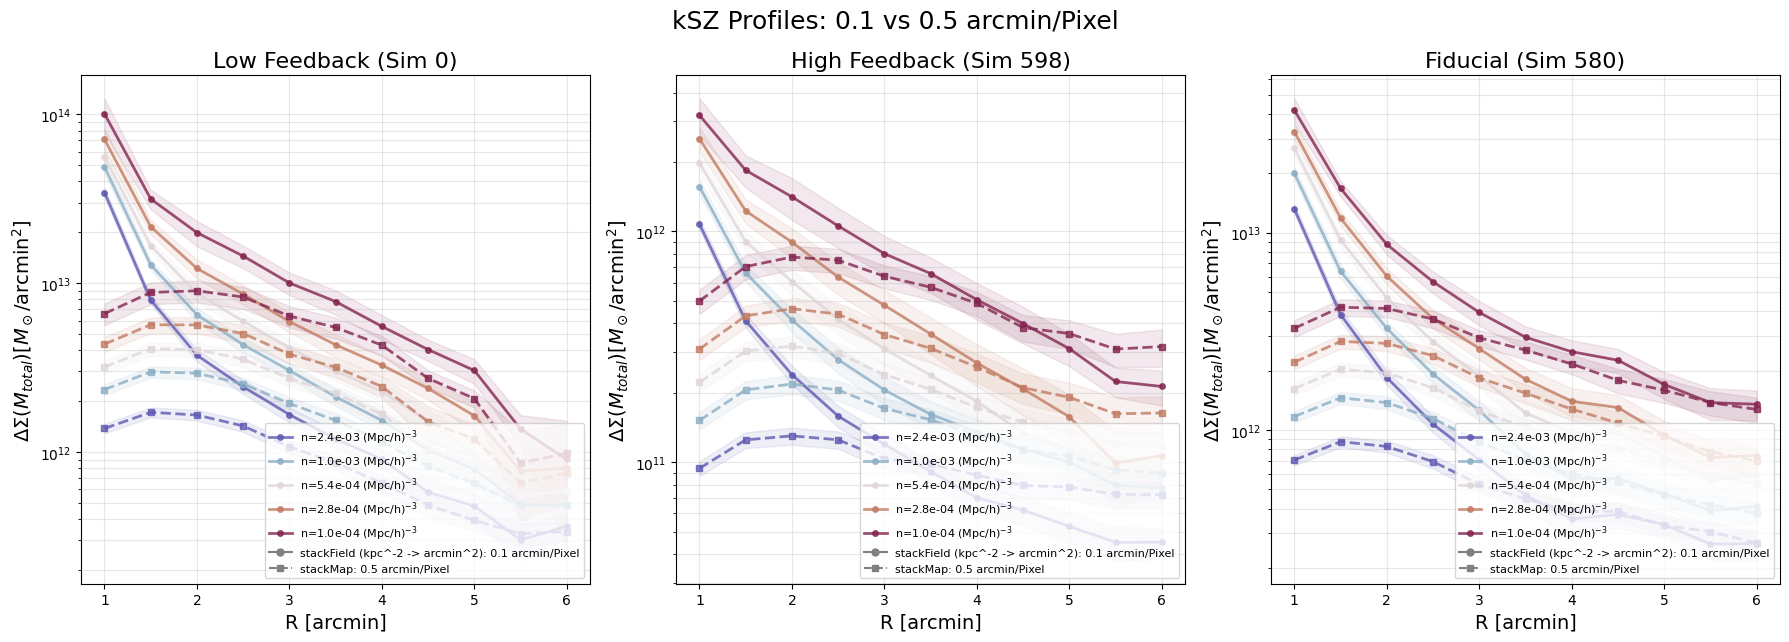

In [27]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Create colormap for number density
colourmap = cm.twilight_shifted
colours = colourmap(np.linspace(0.2, 0.85, len(number_density)))

# Different line styles for pixel sizes
linestyles = ['-', '--']  # solid for 0.1 arcmin/pixel, dashed for 0.5 arcmin/pixel
markers = ['o', 's']  # circle for 0.1, square for 0.5
pixel_sizes = [0.1, 0.5]
profile_sets = [DSigma_profiles1_stackField_all_sims, DSigma_profiles1_stackMap_all_sims]
labels_pixel = ['stackField (kpc^-2 -> arcmin^2): 0.1 arcmin/Pixel', 'stackMap: 0.5 arcmin/Pixel']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    
    if sim_index == 0:
        title_label = f'Low Feedback (Sim {sims[sim_index]})'
    elif sim_index == 1:
        title_label = f'High Feedback (Sim {sims[sim_index]})'
    else:
        title_label = f'Fiducial (Sim {sims[sim_index]})'
    
    # Iterate over pixel sizes (profiles0_all_sims and profiles1_all_sims)
    for ps_idx, profiles_set in enumerate(profile_sets):
        profiles_all = profiles_set[sim_index]
              
        # Iterate over number densities
        for i in range(len(number_density)):
            profiles = profiles_all[i][:numRadii, :]
            # if ps_idx == 0:
            #     profiles = np.array(profiles) * HubbleParams[sim_index]**2    

            color = colours[i]
            ls = linestyles[ps_idx]
            marker = markers[ps_idx]
            
            # Calculate mean and std
            profiles_plot = np.mean(profiles, axis=1)
            profiles_err = np.std(profiles, axis=1) / np.sqrt(profiles.shape[1])
            
            # Create label - only show once per combination
            if ps_idx == 0:  # Only label for 0.1 arcmin/pixel
                label = f'n={number_density[i]:.1e} (Mpc/h)$^{{-3}}$'
            else:
                label = None
            
            # Plot
            ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls=ls, alpha=0.8, 
                   marker=marker, markersize=4, color=color, label=label)
            
            # Fill between for uncertainty
            upper = profiles_plot + profiles_err
            lower = profiles_plot - profiles_err
            ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)
    
    # Create custom legend with organized sections
    handles, labels = ax.get_legend_handles_labels()
    
    # Add custom handles for pixel size styles
    style_handles = [
        Line2D([0], [0], color='gray', ls=linestyles[0], marker=markers[0], markersize=5, label=labels_pixel[0]),
        Line2D([0], [0], color='gray', ls=linestyles[1], marker=markers[1], markersize=5, label=labels_pixel[1])
    ]
    
    # Combine: first DESI, then density labels, then style labels
    all_handles = handles + style_handles
    all_labels = labels + labels_pixel
    
    ax.set_xlabel('R [arcmin]', fontsize=14)
    ax.set_ylabel(r'$\Delta \Sigma (M_{total}) [M_\odot / \mathrm{arcmin}^2]$', fontsize=14)
    ax.set_yscale('log')
    ax.legend(handles=all_handles, labels=all_labels, loc='lower right', fontsize=8, ncol=1)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_title(title_label, fontsize=16)
    ax.set_box_aspect(1)

fig.suptitle('kSZ Profiles: 0.1 vs 0.5 arcmin/Pixel', fontsize=18, y=1.02)
fig.tight_layout()

plt.show()


(21, 231) (21, 231)
(21, 98) (21, 98)
(21, 56) (21, 56)
(21, 29) (21, 29)
(21, 10) (21, 10)
(21, 199) (21, 199)
(21, 80) (21, 80)
(21, 42) (21, 42)
(21, 20) (21, 20)
(21, 7) (21, 7)
(21, 200) (21, 200)
(21, 81) (21, 81)
(21, 42) (21, 42)
(21, 25) (21, 25)
(21, 9) (21, 9)


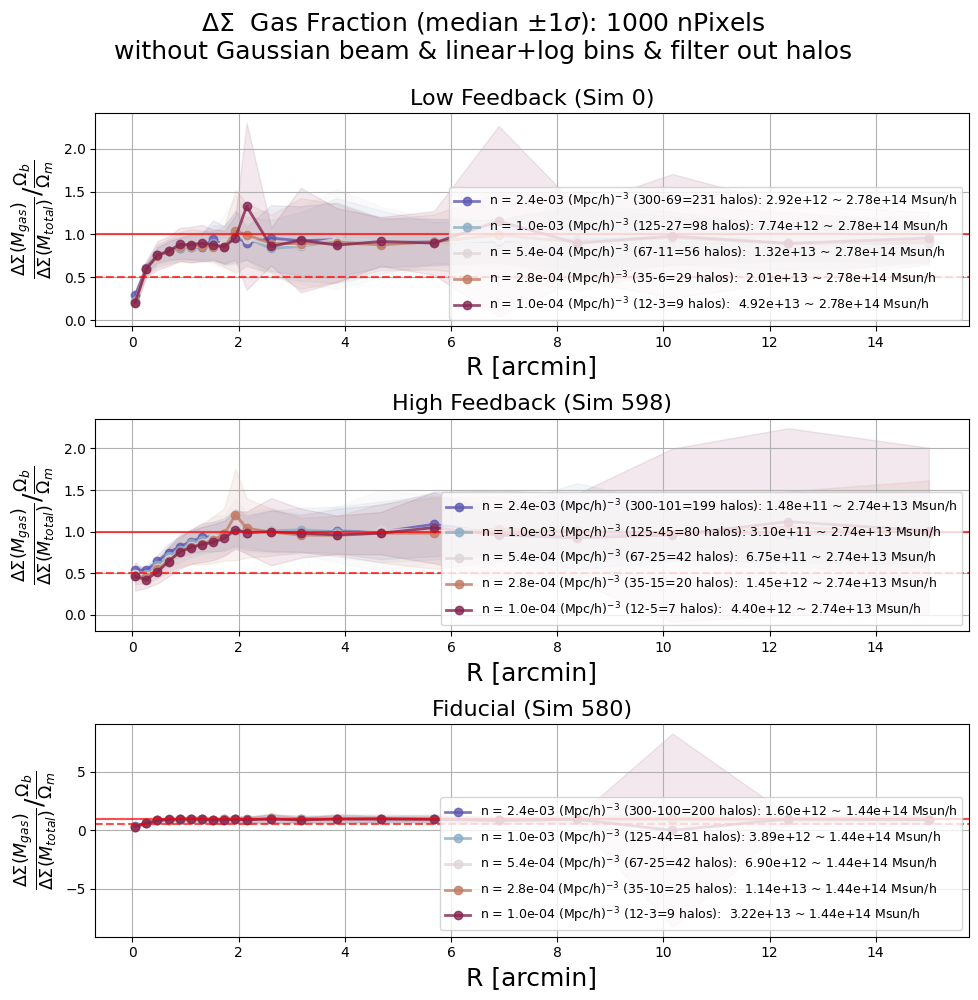

Processing completed in 1414.79 seconds


In [15]:
import matplotlib.cm as cm
import matplotlib.colors as colors
colourmap = cm.twilight_shifted
colors_list = colourmap(np.linspace(0.2, 0.85,  len(number_density)))


# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = DSigma_profiles0_stackField_all_sims[sim_index]
    profiles1_all = DSigma_profiles1_stackField_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i]
        profiles1 = profiles1_all[i]

        print(profiles0.shape, profiles1.shape)
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            title_label = f'Low Feedback (Sim {sims[sim_index]})'
        elif sim_index == 1:
            title_label = f'High Feedback (Sim {sims[sim_index]})'
        else:
            title_label = f'Fiducial (Sim {sims[sim_index]})'
            
        ax.plot(radii1 * radDistance, profiles_plot, lw=2, ls='-', alpha=0.8, marker='o', color=color, 
                       label=mass_dropped_strings[sim_index][i])

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii1 * radDistance, lower, upper, color=color, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(y=1.0, color='red', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.set_ylabel(r'$\frac{\Delta \Sigma (M_{gas})}{\Delta \Sigma (M_{total})}/\frac{\Omega_{b}}{\Omega_{m}} $', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label}', fontsize=16)

fig.suptitle(r'$\Delta \Sigma$  Gas Fraction (median $\pm 1 \sigma$): 1000 nPixels' + '\n' + 'without Gaussian beam & linear+log bins & filter out halos', fontsize=18, y=0.995)
# fig.suptitle(r'$\Delta \Sigma$ Gas Fraction (median $\pm 1 \sigma$): 0.12 arcmin/Pixel', fontsize=18, y=0.995)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

(11, 300) (11, 300)
(11, 125) (11, 125)
(11, 67) (11, 67)
(11, 35) (11, 35)
(11, 12) (11, 12)
(11, 300) (11, 300)
(11, 125) (11, 125)
(11, 67) (11, 67)
(11, 35) (11, 35)
(11, 12) (11, 12)
(11, 300) (11, 300)
(11, 125) (11, 125)
(11, 67) (11, 67)
(11, 35) (11, 35)
(11, 12) (11, 12)


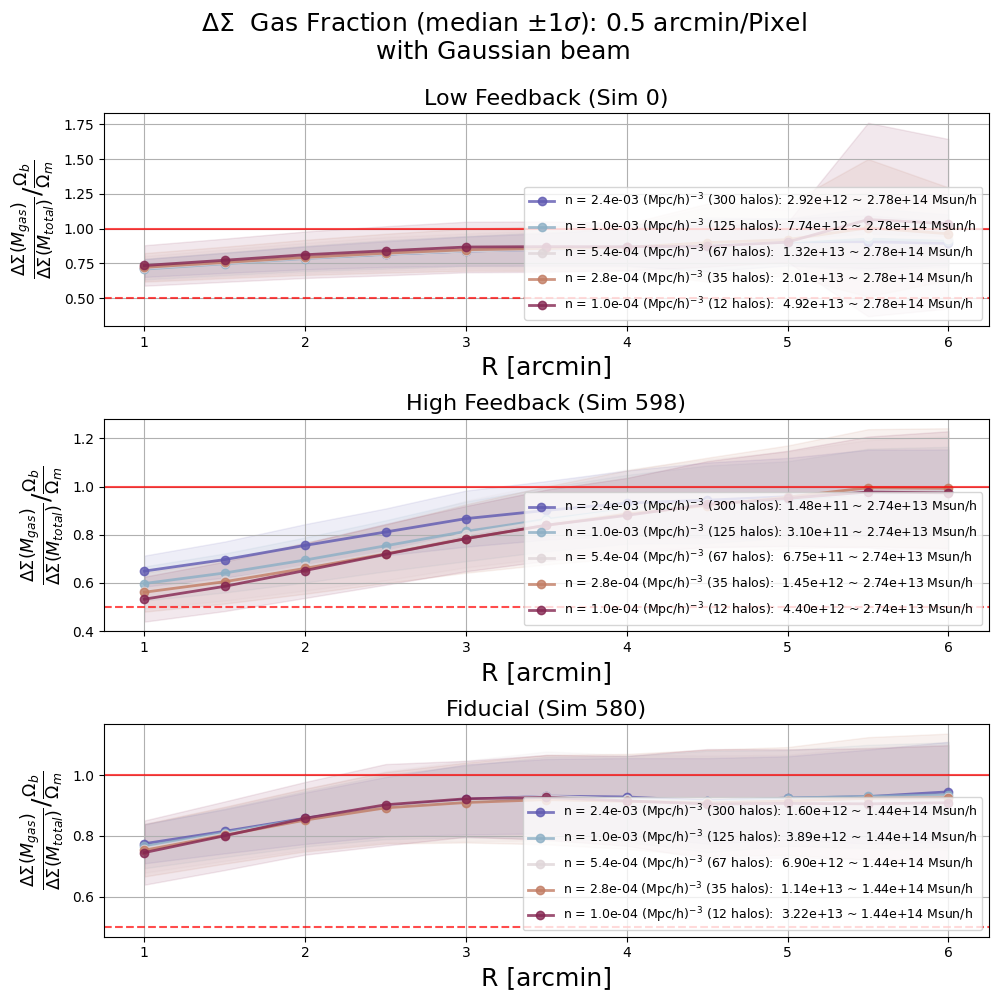

Processing completed in 7462.23 seconds


In [108]:
import matplotlib.cm as cm
import matplotlib.colors as colors
colourmap = cm.twilight_shifted
colors_list = colourmap(np.linspace(0.2, 0.85,  len(number_density)))
radii0 = np.linspace(minRadius_arcmin, maxRadius_arcmin, numRadii)


# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Define cosmology#
# Plotting calculations
T_CMB = 2.7255
v_c = 300000 / 299792458  # velocity over speed of light
num_halos =  [25, 68, 75, 125, 300]
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    profiles0_all = DSigma_profiles0_stackMap_all_sims[sim_index]
    profiles1_all = DSigma_profiles1_stackMap_all_sims[sim_index]
    OmegaB = OmegaBaryons[sim_index]
    OmegaM = OmegaMatters[sim_index]
    
    for i in range(len(number_density)):
        profiles0 = profiles0_all[i]
        profiles1 = profiles1_all[i]

        print(profiles0.shape, profiles1.shape)
        # Calculate profile ratios with error propagation
        profiles_plot = np.mean(profiles0, axis=1) / np.mean(profiles1, axis=1) / (OmegaB / OmegaM)

        # Create plot
        # Use different colors for each plot
        color = colors_list[i]
        
        if sim_index == 0:
            title_label = f'Low Feedback (Sim {sims[sim_index]})'
        elif sim_index == 1:
            title_label = f'High Feedback (Sim {sims[sim_index]})'
        else:
            title_label = f'Fiducial (Sim {sims[sim_index]})'
            
        ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls='-', alpha=0.8, marker='o', color=color, 
                       label=mass_strings[sim_index][i])

        # Calculate error propagation for ratio
        err0 = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
        err1 = np.std(profiles1, axis=1) / np.sqrt(profiles1.shape[1])
        profiles_err = np.abs(profiles_plot) * np.sqrt(
            (err0 / np.mean(profiles0, axis=1))**2 + 
            (err1 / np.mean(profiles1, axis=1))**2
        )

        upper = profiles_plot + profiles_err
        lower = profiles_plot - profiles_err
        ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)

    # Set labels and formatting for each subplot
    ax.set_xlabel('R [arcmin]', fontsize=18)
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(y=1.0, color='red', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.set_ylabel(r'$\frac{\Delta \Sigma (M_{gas})}{\Delta \Sigma (M_{total})}/\frac{\Omega_{b}}{\Omega_{m}} $', fontsize=18)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True)
    ax.set_title(f'{title_label}', fontsize=16)

fig.suptitle(r'$\Delta \Sigma$  Gas Fraction (median $\pm 1 \sigma$): 0.5 arcmin/Pixel' + '\n' + 'with Gaussian beam', fontsize=18, y=0.995)
# fig.suptitle(r'$\Delta \Sigma$ Gas Fraction (median $\pm 1 \sigma$): 0.12 arcmin/Pixel', fontsize=18, y=0.995)

fig.tight_layout()
plt.show()

print(f'Processing completed in {time.time() - t0:.2f} seconds')

# kSZ

In [4]:

# Get colormap
colourmap = matplotlib.colormaps[colourmaps[0]]
colours = [colourmap(0.5)]  # Single color since we have one simulation

if verbose:
    print(f"Processing simulation of type: {sim_type}")

profiles0_all_sims = []
profiles1_all_sims = []
OmegaBaryons = []
OmegaMatters = []
HubbleParams = []
for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)
    stacker_tot = SimulationStacker(s, snapshot, 
                                simType=sim_type)

    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])
    HubbleParams.append(stacker.header['HubbleParam'])

    
    ## Corresponding to halo number in 50 Mpc/h box: [25, 68, 75, 125, 300]
    profiles0_all = []
    profiles1_all = []
    for n_density in number_density:
        radii0, profiles0 = stacker.stackMap('tau', filterType='CAP', minRadius=1.0, maxRadius=6.0,
                                            save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
                                            projection=projection,pixelSize=0.1)
        radii1, profiles1 = stacker_tot.stackMap('tau', filterType='CAP', minRadius=1.0, maxRadius=6.0,
                                                save=saveField, load=loadField, radDistance=radDistance, halo_number_density=n_density,
                                                projection=projection, mask=maskHaloes, maskRad=maskRadii)

        profiles0_all.append(profiles0)
        profiles1_all.append(profiles1)

    profiles0_all_sims.append(profiles0_all)
    profiles1_all_sims.append(profiles1_all)


Processing simulation: L50n512_SB35 simulation 0
Box size: 50000.0 kpc/h , Map size at z=0.4674218694859129: 146.16 arcmin
Processed 0 snapshots, time elapsed: 3.42 seconds
Processed 1 snapshots, time elapsed: 7.00 seconds
Processed 2 snapshots, time elapsed: 10.14 seconds
Processed 3 snapshots, time elapsed: 13.48 seconds
Processed 4 snapshots, time elapsed: 16.91 seconds
Processed 5 snapshots, time elapsed: 20.22 seconds
Processed 6 snapshots, time elapsed: 23.40 seconds
Processed 7 snapshots, time elapsed: 26.60 seconds
Processed 8 snapshots, time elapsed: 29.84 seconds
Processed 9 snapshots, time elapsed: 33.11 seconds
Processed 10 snapshots, time elapsed: 36.25 seconds
Processed 11 snapshots, time elapsed: 39.51 seconds
Processed 12 snapshots, time elapsed: 42.65 seconds
Processed 13 snapshots, time elapsed: 46.16 seconds
Processed 14 snapshots, time elapsed: 49.27 seconds
Processed 15 snapshots, time elapsed: 52.46 seconds
hist2d time: 52.45660400390625
Number of halos selected: 

In [45]:
kSZ_profiles0_all_sims = profiles0_all_sims
kSZ_profiles1_all_sims = profiles1_all_sims

In [41]:
print(f'{stacker.halo_mass_selected.max():.2e}')

2.78e+14


In [34]:
# Save data in a format that handles variable array sizes
save_data = {}
save_data['radii0'] = radii0
save_data['number_density'] = number_density
save_data['sims'] = sims
save_data['mass_strings'] = np.array(mass_dropped_strings, dtype=object)

# Save tau and total profiles separately for each sim and density
for sim_idx, sim_id in enumerate(sims):
    for density_idx, density in enumerate(number_density):
        key0 = f'sim{sim_id}_density{density_idx}_pixelSize_0.1'
        key1 = f'sim{sim_id}_density{density_idx}_pixelSize_0.5'

        save_data[key0] = kSZ_profiles0_all_sims[sim_idx][density_idx]
        save_data[key1] = kSZ_profiles1_all_sims[sim_idx][density_idx]

np.savez(
    f"CAMELS_{sim_name}_tau_CAP_profiles_low_high_fiducial_feedback_small_default_pixelSize_filter_edge_halo.npz",
    **save_data
)


In [ ]:
# Load the saved data
loaded_data = np.load(f"CAMELS_{sim_name}_tau_CAP_profiles_low_high_fiducial_feedback_small_default_pixelSize_filter_edge_halo.npz")

# Extract the basic arrays
radii0 = loaded_data['radii0']
number_density = loaded_data['number_density']
sims = loaded_data['sims']

# Reconstruct the profiles arrays
kSZ_profiles0_all_sims = []
kSZ_profiles1_all_sims = []

for sim_idx, sim_id in enumerate(sims):
    profiles0_all = []
    profiles1_all = []
    
    for density_idx, density in enumerate(number_density):
        key0 = f'sim{sim_id}_density{density_idx}_pixelSize_0.1'
        key1 = f'sim{sim_id}_density{density_idx}_pixelSize_0.5'
        
        profiles0_all.append(loaded_data[key0])
        profiles1_all.append(loaded_data[key1])
    
    kSZ_profiles0_all_sims.append(profiles0_all)
    kSZ_profiles1_all_sims.append(profiles1_all)

print(f"Loaded data for {len(sims)} simulations with {len(number_density)} density bins")
print(f"Shape check - Sim 0, Density 0, 0.1 arcmin: {loaded_data[f'sim{sims[0]}_density0_pixelSize_0.1'].shape}")


Loaded data for 3 simulations with 5 density bins
Shape check - Sim 0, Density 0, 0.1 arcmin: (11, 300)


In [61]:

# Check if all larger number density samples include the halos of smaller number densities in kSZ_profiles0_all_sims
def check_inclusion_by_columns(profiles_list, rtol=1e-6, atol=1e-8):
    """
    Heuristic: treat each halo as its full column vector over radii.
    Check if every column in 'smaller' exists (approximately) in 'larger'.
    """
    for sim_idx, sim_profiles in enumerate(profiles_list):
        print(f"Simulation {sims[sim_idx]}:")
        for i in range(len(number_density) - 1):
            larger = sim_profiles[i]      # shape: (numRadii, numHalos_larger)
            smaller = sim_profiles[i + 1] # shape: (numRadii, numHalos_smaller)
            print("shapes:", larger.shape, smaller.shape)

            # Build fingerprints for larger set: tuples of rounded values across all radii
            # Using rounding to mitigate tiny numeric noise
            larger_fps = {tuple(np.round(larger[:, j], 8)) for j in range(larger.shape[1])}

            # Count how many smaller columns are found in larger
            missing = []
            for j in range(smaller.shape[1]):
                fp = tuple(np.round(smaller[:, j], 8))
                if fp not in larger_fps:
                    missing.append(j)

            if missing:
                print(f"  Missing {len(missing)} of {smaller.shape[1]} halos from larger density at indices: {missing[:10]}{'...' if len(missing)>10 else ''}")
            else:
                print(f"  All {smaller.shape[1]} halos are included.")
    print("Column-based check complete.")

# Run the heuristic check
check_inclusion_by_columns(kSZ_profiles0_all_sims)

Simulation 0:
shapes: (11, 234) (11, 103)
  All 103 halos are included.
shapes: (11, 103) (11, 56)
  All 56 halos are included.
shapes: (11, 56) (11, 30)
  All 30 halos are included.
shapes: (11, 30) (11, 10)
  All 10 halos are included.
Simulation 598:
shapes: (11, 190) (11, 77)
  All 77 halos are included.
shapes: (11, 77) (11, 36)
  All 36 halos are included.
shapes: (11, 36) (11, 16)
  All 16 halos are included.
shapes: (11, 16) (11, 6)
  All 6 halos are included.
Simulation 580:
shapes: (11, 210) (11, 93)
  All 93 halos are included.
shapes: (11, 93) (11, 53)
  All 53 halos are included.
shapes: (11, 53) (11, 26)
  All 26 halos are included.
shapes: (11, 26) (11, 8)
  All 8 halos are included.
Column-based check complete.


In [19]:
DESI_data = np.load('Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz')
print(DESI_data.keys())

KeysView(NpzFile 'Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz' with keys: theta_arcmins, prof, cov)


(11, 234)
(11, 103)
(11, 56)
(11, 30)
(11, 10)
(11, 234)
(11, 103)
(11, 56)
(11, 30)
(11, 10)
(11, 190)
(11, 77)
(11, 36)
(11, 16)
(11, 6)
(11, 183)
(11, 73)
(11, 34)
(11, 15)
(11, 5)
(11, 210)
(11, 93)
(11, 53)
(11, 26)
(11, 8)
(11, 209)
(11, 93)
(11, 53)
(11, 26)
(11, 8)


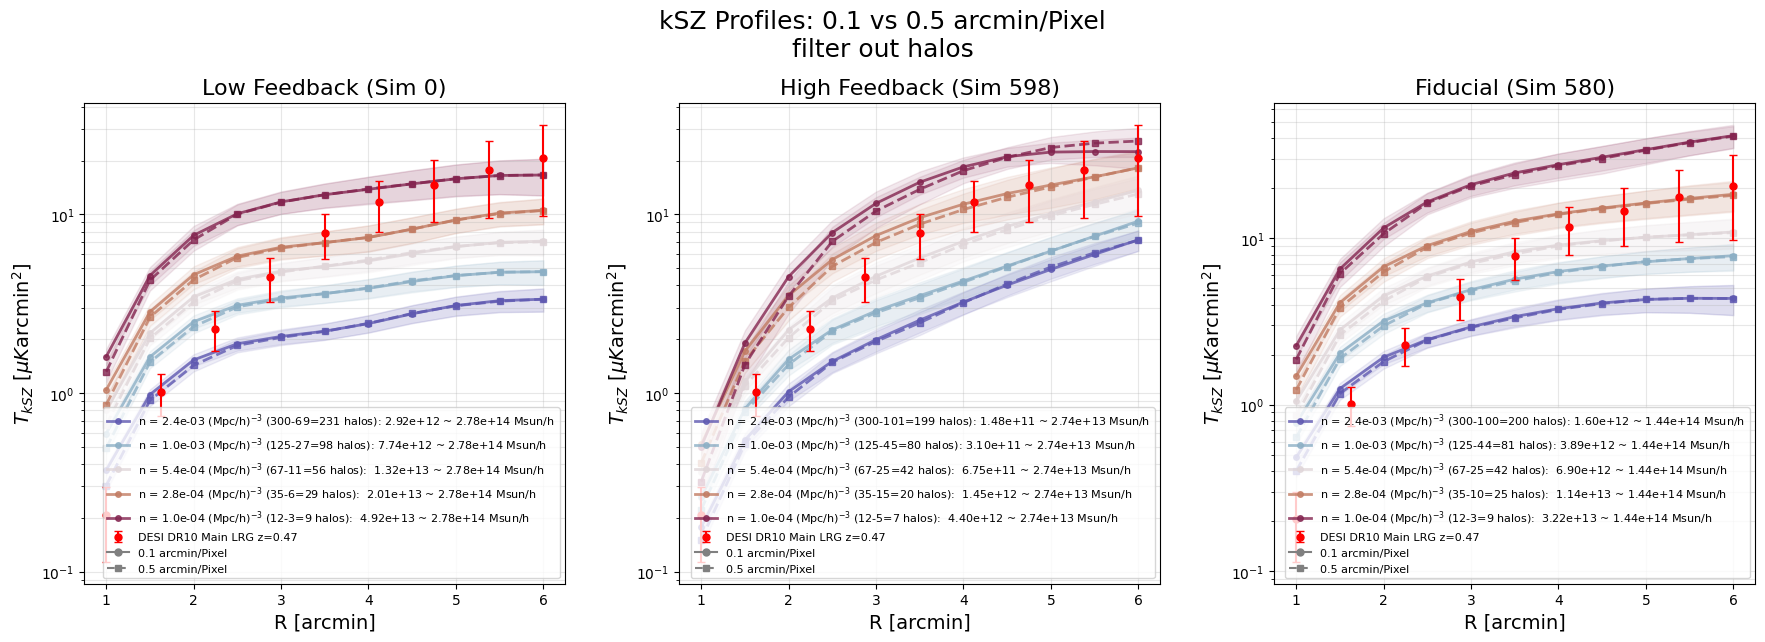

In [ ]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Create colormap for number density
colourmap = cm.twilight_shifted
colours = colourmap(np.linspace(0.2, 0.85, len(number_density)))

# Different line styles for pixel sizes
linestyles = ['-', '--']  # solid for 0.1 arcmin/pixel, dashed for 0.5 arcmin/pixel
markers = ['o', 's']  # circle for 0.1, square for 0.5
pixel_sizes = [0.1, 0.5]
profile_sets = [kSZ_profiles0_all_sims, kSZ_profiles1_all_sims]
# profile_sets = [profiles0_all_sims, profiles1_all_sims]
labels_pixel = ['0.1 arcmin/Pixel', '0.5 arcmin/Pixel']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    
    if sim_index == 0:
        title_label = f'Low Feedback (Sim {sims[sim_index]})'
    elif sim_index == 1:
        title_label = f'High Feedback (Sim {sims[sim_index]})'
    else:
        title_label = f'Fiducial (Sim {sims[sim_index]})'
    
    # Iterate over pixel sizes (profiles0_all_sims and profiles1_all_sims)
    for ps_idx, profiles_set in enumerate(profile_sets):
        profiles_all = profiles_set[sim_index]
        
        # Iterate over number densities
        for i in range(len(number_density)):
            profiles = profiles_all[i]
            color = colours[i]
            ls = linestyles[ps_idx]
            marker = markers[ps_idx]
            
            # Calculate mean and std
            profiles_plot = np.mean(profiles, axis=1)
            profiles_err = np.std(profiles, axis=1) / np.sqrt(profiles.shape[1])
            
            # Create label - only show once per combination
            if ps_idx == 0:  # Only label for 0.1 arcmin/pixel
                label = mass_dropped_strings[sim_index][i] #f'n={number_density[i]:.1e} (Mpc/h)$^{{-3}}$'
            else:
                label = None
            
            # Plot
            ax.plot(radii0 * radDistance, profiles_plot, lw=2, ls=ls, alpha=0.8, 
                   marker=marker, markersize=4, color=color, label=label)
            
            # Fill between for uncertainty
            upper = profiles_plot + profiles_err
            lower = profiles_plot - profiles_err
            ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)
    
    # Add DESI data to all plots
    ax.errorbar(DESI_data['theta_arcmins'], DESI_data['prof'], 
               yerr=np.sqrt(DESI_data['cov'].diagonal()), 
               fmt='o', capsize=3, capthick=1, linewidth=1.5, markersize=5, 
               color='red', label='DESI DR10 Main LRG z=0.47', zorder=4)
    
    # Create custom legend with organized sections
    handles, labels = ax.get_legend_handles_labels()
    
    # Add custom handles for pixel size styles
    style_handles = [
        Line2D([0], [0], color='gray', ls='-', marker='o', markersize=5, label='0.1 arcmin/Pixel'),
        Line2D([0], [0], color='gray', ls='--', marker='s', markersize=5, label='0.5 arcmin/Pixel')
    ]
    
    # Combine: first DESI, then density labels, then style labels
    all_handles = handles + style_handles
    all_labels = labels + ['0.1 arcmin/Pixel', '0.5 arcmin/Pixel']
    
    ax.set_xlabel('R [arcmin]', fontsize=14)
    ax.set_ylabel(r'$T_{kSZ}$ [$\mu K \rm{arcmin}^2$]', fontsize=14)
    ax.set_yscale('log')
    ax.legend(handles=all_handles, labels=all_labels, loc='lower right', fontsize=8, ncol=1)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_title(title_label, fontsize=16)
    ax.set_box_aspect(1)

fig.suptitle('kSZ Profiles: 0.1 vs 0.5 arcmin/Pixel'+ '\n' + 'filter out halos', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()


# $T_{kSZ} / \Delta \Sigma$

kSZ_profiles1_all_sims/ kSZ_from_DSigma_profiles1_all_sims 



In [110]:
kSZ_from_DSigma_profiles1_all_sims = []
pixelArea_kpc = []
print(f'Before transformation: Delta Sigma Unit ~ f{np.mean(DSigma_profiles1_stackField_all_sims[0][0]):.1e} M_sun/kpc^2')


for sim_idx, sim_id in enumerate(sims):
    profiles= []
    cosmo = FlatLambdaCDM(H0=100 * HubbleParams[sim_idx], Om0=OmegaMatters[sim_idx], Tcmb0=2.7255 * u.K, Ob0=OmegaBaryons[sim_idx])          
    # pixelArea = arcmin_to_comoving(0.5, redshift, cosmo)**2
    # pixelArea_kpc.append(pixelArea)
    for density_idx, density in enumerate(number_density):
        # TODO: 10e10 Msun/kpc^2 ??
        data = ksz_from_delta_sigma(DSigma_profiles1_stackField_all_sims[sim_idx][density_idx] * u.Msun /  u.kpc**2 * HubbleParams[sim_idx]**2, redshift, delta_sigma_is_comoving=True, cosmology=cosmo) 
        profiles.append(np.abs(data))
    
    kSZ_from_DSigma_profiles1_all_sims.append(profiles)
print(f'After transformation: T_kSZ Unit ~ f{np.mean(kSZ_from_DSigma_profiles1_all_sims[0][0]):.2e} mu K')

Before transformation: Delta Sigma Unit ~ f8.4e+11 M_sun/kpc^2
After transformation: T_kSZ Unit ~ f1.05e+04 mu K


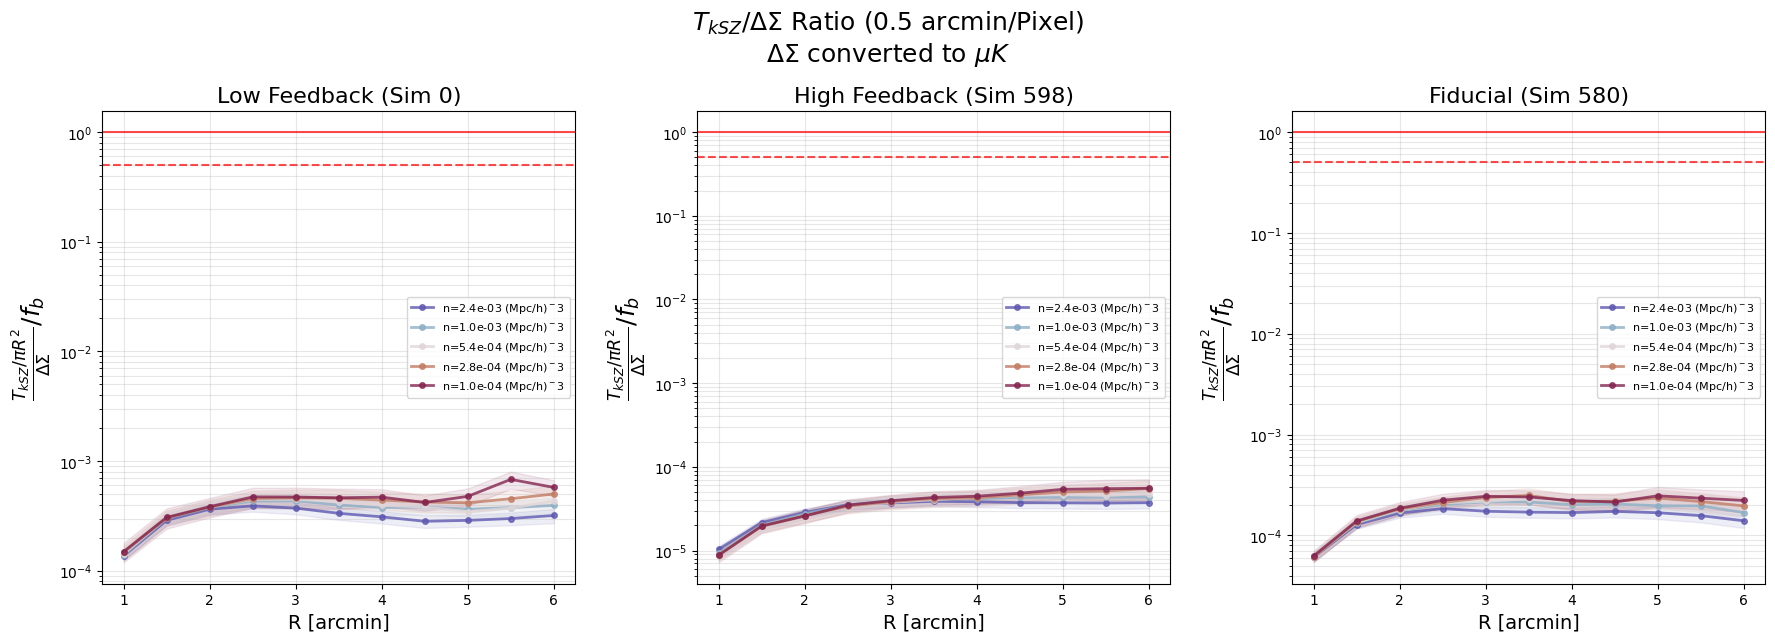

In [112]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Create colormap for number density
colourmap = cm.twilight_shifted
colours = colourmap(np.linspace(0.2, 0.85, len(number_density)))
radii0 = np.linspace(minRadius_arcmin, maxRadius_arcmin, numRadii)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for sim_index in range(len(sims)):
    ax = axes[sim_index]
    fb = OmegaBaryons[sim_index]/OmegaMatters[sim_index]
    if sim_index == 0:
        title_label = f'Low Feedback (Sim {sims[sim_index]})'
    elif sim_index == 1:
        title_label = f'High Feedback (Sim {sims[sim_index]})'
    else:
        title_label = f'Fiducial (Sim {sims[sim_index]})'
    
    # Get kSZ and DSigma profiles for this simulation (using default pixel size)
    ksz_profiles_all = kSZ_profiles1_all_sims[sim_index]
    dsigma_profiles_all = kSZ_from_DSigma_profiles1_all_sims[sim_index]
    
    # Iterate over number densities
    for i in range(len(number_density)):
        # muK arcmin^2 --> muK

        ksz_profiles = ksz_profiles_all[i] / (np.pi * radii0[:, None]**2*0.5**2) # CAP area: (-1)(sqrt(2)r)**2 - (1) r**2 = r**2

        dsigma_profiles = dsigma_profiles_all[i][:numRadii,:]
        color = colours[i]
        
        # Calculate ratio with error propagation
        ksz_mean = np.mean(ksz_profiles, axis=1)
        dsigma_mean = np.mean(dsigma_profiles, axis=1)
        
        # Calculate ratio: kSZ / kSZ_from_DSigma
        # Note: radii are already in the correct units
        ratio_plot = ksz_mean / dsigma_mean / fb
        
        # Error propagation for ratio
        ksz_err = np.std(ksz_profiles, axis=1) / np.sqrt(ksz_profiles.shape[1])
        dsigma_err = np.std(dsigma_profiles, axis=1) / np.sqrt(dsigma_profiles.shape[1])
        
        ratio_err = np.abs(ratio_plot) * np.sqrt(
            (ksz_err / ksz_mean)**2 + 
            (dsigma_err / dsigma_mean)**2
        )
        
        label = f'n={number_density[i]:.1e} (Mpc/h)$^{-3}$'
        
        # Plot
        ax.plot(radii0 * radDistance, ratio_plot, lw=2, ls='-', alpha=0.8, 
               marker='o', markersize=4, color=color, label=label)
        
        # Fill between for uncertainty
        upper = ratio_plot + ratio_err
        lower = ratio_plot - ratio_err
        ax.fill_between(radii0 * radDistance, lower, upper, color=color, alpha=0.1)
    
    ax.axhline(y=1.0, color='red', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('R [arcmin]', fontsize=14)
    ax.set_ylabel(r'$\frac{T_{kSZ} / \pi R^2}{\Delta \Sigma}/ f_b$', fontsize=18)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=8, ncol=1)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_title(title_label, fontsize=16)
    ax.set_box_aspect(1)

fig.suptitle(r'$T_{kSZ} / \Delta \Sigma$ Ratio (0.5 arcmin/Pixel)' + '\n' + r'$\Delta \Sigma$ converted to $\mu K$', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

# $P_k$ Suppression

In [31]:
sims = [0]

# Get colormap
colourmap = matplotlib.colormaps[colourmaps[0]]
colours = [colourmap(0.5)]  # Single color since we have one simulation

if verbose:
    print(f"Processing simulation of type: {sim_type}")

Pk_results_all_sims = []
OmegaBaryons = []
OmegaMatters = []
HubbleParams = []

for s in sims:
    print(f"Processing simulation: {sim_name} simulation {s}")

    stacker = SimulationStacker(s, snapshot, 
                        simType=sim_type)


    OmegaBaryons.append(stacker.header['OmegaBaryon'])
    OmegaMatters.append(stacker.header['Omega0'])
    HubbleParams.append(stacker.header['HubbleParam'])

    
    results  = stacker.get_field_baryon_suppression(save=True)

    Pk_results_all_sims.append(results)


Processing simulation: L50n512_SB35 simulation 0
Computing 3D density fields at grid resolution 512^3...
Computing DM field...
Processed 0 snapshots, time elapsed: 2.65 seconds
Processed 0 snapshots, time elapsed: 2.65 seconds
Processed 10 snapshots, time elapsed: 25.03 seconds
Processed 10 snapshots, time elapsed: 25.03 seconds
Binned statistic time: 36.56941246986389
Computing total matter field...
Processing particle type: gas
Data file '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/gas_512_3Dfield.npy' not found. Please compute it first.
Computing the field instead...
Binned statistic time: 36.56941246986389
Computing total matter field...
Processing particle type: gas
Data file '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_0/data/gas_512_3Dfield.npy' not found. Please compute it first.
Computing the field instead...
Processed 0 snapshots, time elapsed: 2.61 seconds
Processed 0 snapshots, time elapsed: 2.61 seconds
Processed 10 snapshots, tim